In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import ticker, patheffects
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [2]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [3]:
# Open NCEP GFS dataset; change name accordingly to yours
ds = xr.open_dataset('US_SYNOPTIC/081416_0600H.f00.nc4')
ds

<xarray.Dataset>
Dimensions:                                            (sigma: 1,
                                                        potential_vorticity_surface: 2,
                                                        latitude: 101,
                                                        isobaric3: 31,
                                                        height_above_ground1: 3,
                                                        isobaric1: 21, time: 1,
                                                        height_above_ground3: 1,
                                                        longitude: 141,
                                                        isobaric4: 26)
Coordinates:
  * sigma                                              (sigma) float64 0.995
    reftime                                            datetime64[ns] ...
  * potential_vorticity_surface                        (potential_vorticity_surface) float64 ...
  * latitude                                           (latitude) float32 25....
  * isobaric3                                          (isobaric3) float64 10...
  * height_above_ground1                               (height_above_ground1) float64 ...
  * isobaric1                                          (isobaric1) float64 1e...
  * time                                               (time) datetime64[ns] ...
  * height_above_ground3                               (height_above_ground3) float64 ...
  * longitude                                          (longitude) float32 10...
  * isobaric4                                          (isobaric4) float64 1e...
Data variables: (12/18)
    Vertical_velocity_pressure_isobaric                (time, isobaric1, latitude, longitude) float32 ...
    Relative_humidity_isobaric                         (time, isobaric3, latitude, longitude) float32 ...
    Temperature_isobaric                               (time, isobaric3, latitude, longitude) float32 ...
    v-component_of_wind_sigma                          (time, sigma, latitude, longitude) float32 ...
    v-component_of_wind_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    u-component_of_wind_height_above_ground            (time, height_above_ground1, latitude, longitude) float32 ...
    ...                                                 ...
    u-component_of_wind_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    Dewpoint_temperature_height_above_ground           (time, height_above_ground3, latitude, longitude) float32 ...
    u-component_of_wind_sigma                          (time, sigma, latitude, longitude) float32 ...
    Vertical_velocity_pressure_sigma                   (time, sigma, latitude, longitude) float32 ...
    Geopotential_height_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E                      int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                         

In [4]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
dew = ds['Dewpoint_temperature_height_above_ground']
mslp = ds['MSLP_Eta_model_reduction_msl']
uwnd = ds['v-component_of_wind_height_above_ground']
vwnd = ds['v-component_of_wind_height_above_ground']

# Select and grab MSLP, U and V-components, and Precip. Water. Apply gaussian_filter
tdk = gaussian_filter(dew.sel(height_above_ground3=2).data[0], sigma=3.0) * units.kelvin
tdc = tdk.to(units.degC)
mslp_surf = gaussian_filter(mslp.data[0], sigma=3.0) * units.pascal
mslp_hpa = mslp_surf.to(units.hectopascal)

uwnd_surf = gaussian_filter(uwnd.sel(height_above_ground1=10).data[0], sigma=3.0) * units('m/s')
vwnd_surf = gaussian_filter(vwnd.sel(height_above_ground1=10).data[0], sigma=3.0) * units('m/s')

vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

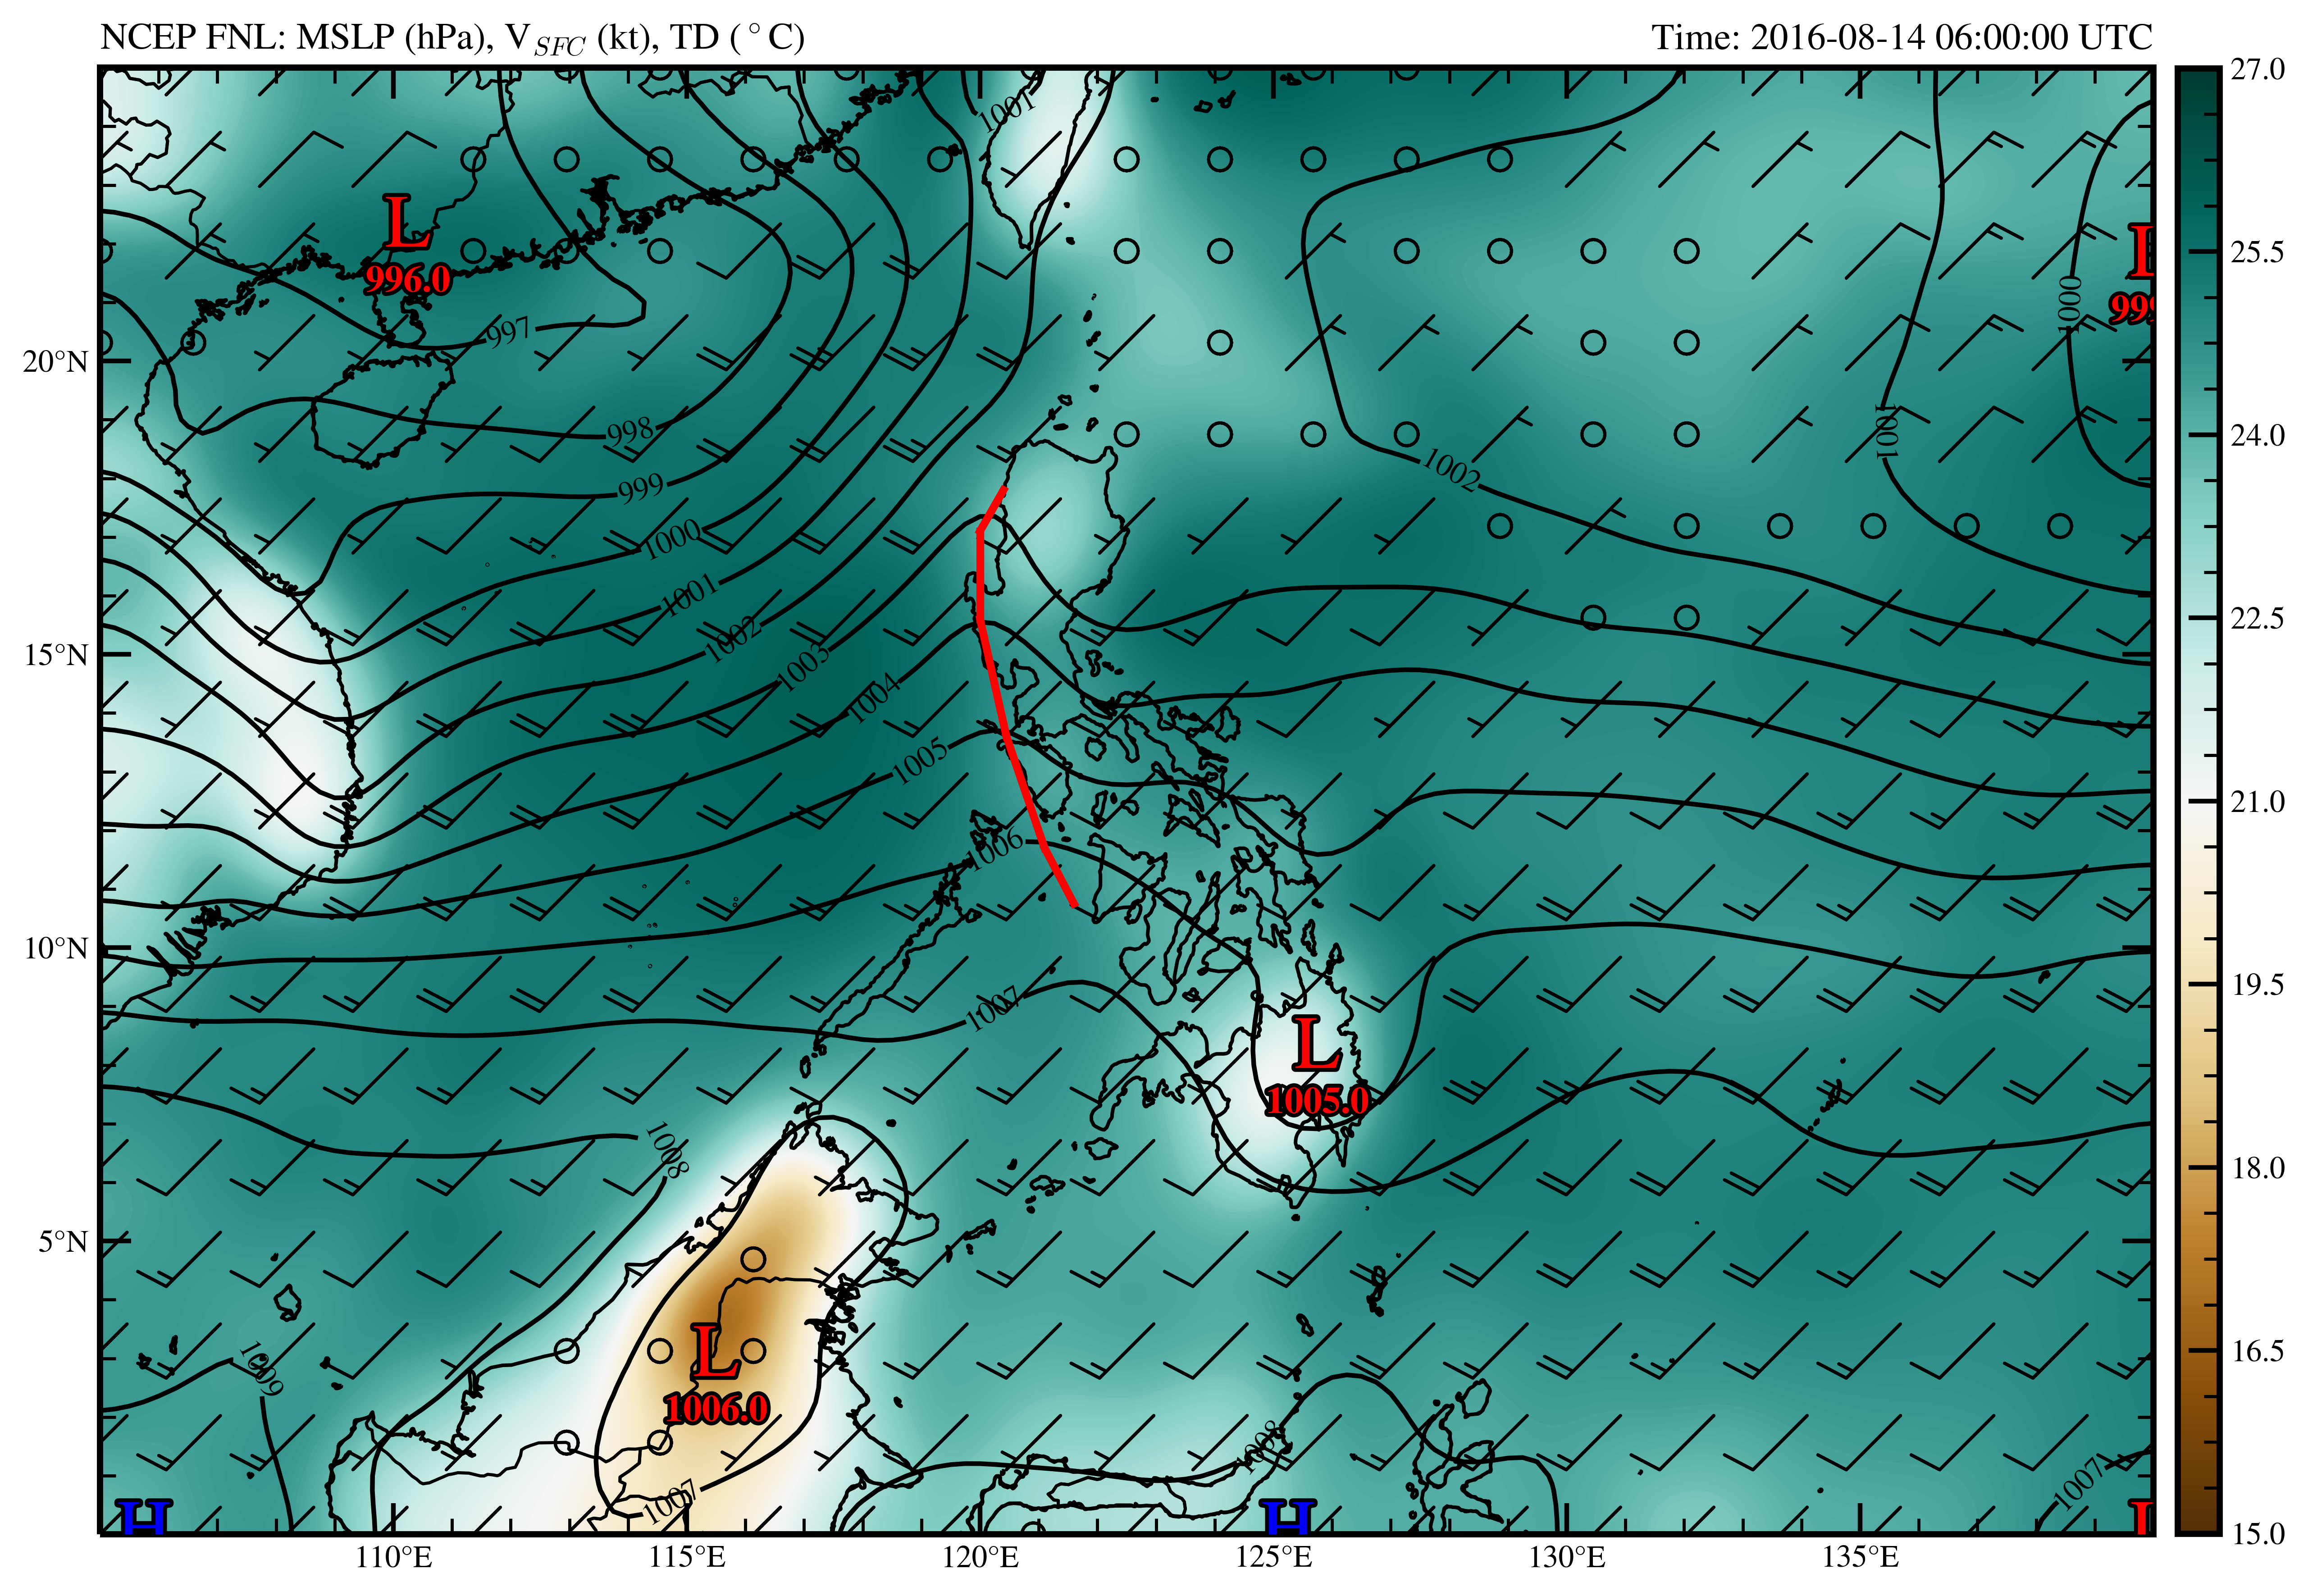

In [15]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], mapcrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill Dewpoint
clevs_850_td = np.arange(15, 27.05, 0.05)
cf = ax.contourf(lons, lats, tdc, clevs_850_td, cmap='BrBG',
                 transform=datacrs)
cbar = plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=35, shrink=0.542)

tick_locator = ticker.MaxNLocator(nbins=10)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add Surface Winds using U and V-components
ax.barbs(lons, lats, uwnd_surf.to('kt').m, vwnd_surf.to('kt').m, pivot='middle',
         color='black', regrid_shape=17, transform=datacrs)

# Plot MSLP Contour
MSLP_range = np.arange(995, 1010, 1)
prs = ax.contour(lons, lats, mslp_hpa, MSLP_range, colors='k',
                 transform=datacrs, zorder=1)
ax.clabel(prs, fmt='%d')

# Create a line(s) that highlights the surface trough
point1 = dict(lon=120.40, lat=17.80)
point2 = dict(lon=120.00, lat=17.10)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point3 = dict(lon=120.00, lat=17.10)
point4 = dict(lon=120.00, lat=15.60)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point5 = dict(lon=120.00, lat=15.60)
point6 = dict(lon=120.45, lat=13.60)
lon_p2 = [point5['lon'], point6['lon']]
lat_p2 = [point5['lat'], point6['lat']]
ax.plot(lon_p2, lat_p2, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point7 = dict(lon=120.45, lat=13.60)
point8 = dict(lon=121.10, lat=11.70)
lon_p3 = [point7['lon'], point8['lon']]
lat_p3 = [point7['lat'], point8['lat']]
ax.plot(lon_p3, lat_p3, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point9 = dict(lon=121.10, lat=11.70)
point10 = dict(lon=121.60, lat=10.75)
lon_p4 = [point9['lon'], point10['lon']]
lat_p4 = [point9['lat'], point10['lat']]
ax.plot(lon_p4, lat_p4, color='red', linewidth=2.5, transform=ccrs.Geodetic())

# Plot Highs and Lows (Min/Max) values of MSLP
plot_maxmin_points(lons, lats, mslp_hpa, 'max', 60, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, mslp_hpa, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('NCEP FNL: MSLP (hPa), V$_{SFC}$ (kt), TD ($^\circ$C)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('MSLP, Zsurf, Td.jpg', bbox_inches="tight")
plt.show()